# Long-Short Strategy, Part 3: Evaluating our Boosting Model Signals

In this section, we'll start designing, implementing, and evaluating a trading strategy for US equities driven by daily return forecasts produced by gradient boosting models.

As in the previous examples, we'll lay out a framework and build a specific example that you can adapt to run your own experiments. There are numerous aspects that you can vary, from the asset class and investment universe to more granular aspects like the features, holding period, or trading rules. See, for example, the **Alpha Factor Library** in the [Appendix](../24_alpha_factor_library) for numerous additional features.

We'll keep the trading strategy simple and only use a single ML signal; a real-life application will likely use multiple signals from different sources, such as complementary ML models trained on different datasets or with different lookahead or lookback periods. It would also use sophisticated risk management, from simple stop-loss to value-at-risk analysis.

**Six notebooks** cover our workflow sequence:

1. [preparing_the_model_data](04_preparing_the_model_data.ipyny): we engineer a few simple features from the Quandl Wiki data 
2. [trading_signals_with_lightgbm_and_catboost](05_trading_signals_with_lightgbm_and_catboost.ipynb): we tune hyperparameters for LightGBM and CatBoost to select a model, using 2015/16 as our validation period. 
3. `evaluate_trading_signals` (this noteboook): we compare the cross-validation performance using various metrics to select the best model. 
4. [model_interpretation](07_model_interpretation.ipynb): we take a closer look at the drivers behind the best model's predictions.
5. [making_out_of_sample_predictions](08_making_out_of_sample_predictions.ipynb): we generate predictions for our out-of-sample test period 2017.
6. [backtesting_with_zipline](09_backtesting_with_zipline.ipynb): evaluate the historical performance of a long-short strategy based on our predictive signals using Zipline.

Cross-validation of numerous configurations has produced a large number of results. Now, we need to evaluate the predictive performance to identify the model that generates the most reliable and profitable signals for our prospective trading strategy.

## Imports & Settings

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

from time import time
from io import StringIO
import sys, os
import warnings
from pathlib import Path
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

import lightgbm as lgb

from scipy.stats import spearmanr, pearsonr

from alphalens import plotting
from alphalens import performance as perf
from alphalens.utils import get_clean_factor_and_forward_returns, rate_of_return, std_conversion
from alphalens.tears import (create_summary_tear_sheet,
                             create_full_tear_sheet)

In [3]:
sys.path.insert(1, os.path.join(sys.path[0], '..'))
from utils import MultipleTimeSeriesCV

In [4]:
sns.set_style('whitegrid')

In [5]:
YEAR = 252
idx = pd.IndexSlice

In [6]:
scope_params = ['lookahead', 'train_length', 'test_length']
daily_ic_metrics = ['daily_ic_mean', 'daily_ic_mean_n', 'daily_ic_median', 'daily_ic_median_n']
lgb_train_params = ['learning_rate', 'num_leaves', 'feature_fraction', 'min_data_in_leaf']
catboost_train_params = ['max_depth', 'min_child_samples']

In [7]:
results_path = Path('results', 'us_stocks')
if not results_path.exists():
    results_path.mkdir(parents=True)

## Collect Data

We produced a larger number of LightGBM models because it runs an order of magnitude faster than CatBoost and will demonstrate some evaluation strategies accordingly.

### LightGBM

#### Summary Metrics by Fold

First, we collect the summary metrics computed for each fold and hyperparameter combination:

In [8]:
with pd.HDFStore(results_path / 'tuning_lgb.h5') as store:
    for i, key in enumerate(
        [k[1:] for k in store.keys() if k[1:].startswith('metrics')]):
        _, t, train_length, test_length = key.split('/')[:4]
        attrs = {
            'lookahead': t,
            'train_length': train_length,
            'test_length': test_length
        }
        s = store[key].to_dict()
        s.update(attrs)
        if i == 0:
            lgb_metrics = pd.Series(s).to_frame(i)
        else:
            lgb_metrics[i] = pd.Series(s)

id_vars = scope_params + lgb_train_params + daily_ic_metrics
lgb_metrics = pd.melt(lgb_metrics.T.drop('t', axis=1), 
                  id_vars=id_vars, 
                  value_name='ic', 
                  var_name='boost_rounds').dropna().apply(pd.to_numeric)

In [9]:
lgb_metrics.to_hdf('data/model_tuning.h5', 'lgb/metrics')
lgb_metrics.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4459 entries, 0 to 4458
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   lookahead          4459 non-null   int64  
 1   train_length       4459 non-null   int64  
 2   test_length        4459 non-null   int64  
 3   learning_rate      4459 non-null   float64
 4   num_leaves         4459 non-null   float64
 5   feature_fraction   4459 non-null   float64
 6   min_data_in_leaf   4459 non-null   float64
 7   daily_ic_mean      4459 non-null   float64
 8   daily_ic_mean_n    4459 non-null   float64
 9   daily_ic_median    4459 non-null   float64
 10  daily_ic_median_n  4459 non-null   float64
 11  boost_rounds       4459 non-null   int64  
 12  ic                 4459 non-null   float64
dtypes: float64(9), int64(4)
memory usage: 487.7 KB


In [10]:
lgb_metrics.groupby(scope_params).size()

lookahead  train_length  test_length
1          252           63             767
           1134          63             715
5          252           63             754
           1134          63             741
21         252           63             741
           1134          63             741
dtype: int64

#### Information Coefficient by Day

Next, we retrieve the IC per day computed during cross-validation:

In [11]:
int_cols = ['lookahead', 'train_length', 'test_length', 'boost_rounds']

In [12]:
lgb_ic = []
with pd.HDFStore(results_path / 'tuning_lgb.h5') as store:
    keys = [k[1:] for k in store.keys()]
    for key in keys:
        _, t, train_length, test_length = key.split('/')[:4]
        if key.startswith('daily_ic'):
            df = (store[key]
                  .drop(['boosting', 'objective', 'verbose'], axis=1)
                 .assign(lookahead=t, 
                         train_length=train_length, 
                         test_length=test_length))
            lgb_ic.append(df)
    lgb_ic = pd.concat(lgb_ic).reset_index()

In [13]:
id_vars = ['date'] + scope_params + lgb_train_params
lgb_ic = pd.melt(lgb_ic, 
                 id_vars=id_vars, 
                 value_name='ic', 
                 var_name='boost_rounds').dropna()
lgb_ic.loc[:, int_cols] = lgb_ic.loc[:, int_cols].astype(int)

In [14]:
lgb_ic.to_hdf('data/model_tuning.h5', 'lgb/ic')
lgb_ic.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2245400 entries, 0 to 2247335
Data columns (total 10 columns):
 #   Column            Non-Null Count    Dtype         
---  ------            --------------    -----         
 0   date              2245400 non-null  datetime64[ns]
 1   lookahead         2245400 non-null  int32         
 2   train_length      2245400 non-null  int32         
 3   test_length       2245400 non-null  int32         
 4   learning_rate     2245400 non-null  float64       
 5   num_leaves        2245400 non-null  int64         
 6   feature_fraction  2245400 non-null  float64       
 7   min_data_in_leaf  2245400 non-null  int64         
 8   boost_rounds      2245400 non-null  int32         
 9   ic                2245400 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int32(4), int64(2)
memory usage: 154.2 MB


In [15]:
lgb_daily_ic = lgb_ic.groupby(id_vars[1:] + ['boost_rounds']).ic.mean().to_frame('ic').reset_index()
lgb_daily_ic.to_hdf('data/model_tuning.h5', 'lgb/daily_ic')
lgb_daily_ic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4459 entries, 0 to 4458
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   lookahead         4459 non-null   int64  
 1   train_length      4459 non-null   int64  
 2   test_length       4459 non-null   int64  
 3   learning_rate     4459 non-null   float64
 4   num_leaves        4459 non-null   int64  
 5   feature_fraction  4459 non-null   float64
 6   min_data_in_leaf  4459 non-null   int64  
 7   boost_rounds      4459 non-null   int64  
 8   ic                4459 non-null   float64
dtypes: float64(3), int64(6)
memory usage: 313.6 KB


In [16]:
lgb_ic = pd.read_hdf('data/model_tuning.h5', 'lgb/ic')
lgb_daily_ic = pd.read_hdf('data/model_tuning.h5', 'lgb/daily_ic')

### CatBoost

We proceed similarly for CatBoost:

#### Summary Metrics

In [17]:
with pd.HDFStore(results_path / 'tuning_catboost.h5') as store:
    for i, key in enumerate(
            [k[1:] for k in store.keys() if k[1:].startswith('metrics')]):
        _, t, train_length, test_length = key.split('/')[:4]
        attrs = {
            'lookahead'   : t,
            'train_length': train_length,
            'test_length' : test_length
        }
        s = store[key].to_dict()
        s.update(attrs)
        if i == 0:
            catboost_metrics = pd.Series(s).to_frame(i)
        else:
            catboost_metrics[i] = pd.Series(s)

id_vars = scope_params + catboost_train_params + daily_ic_metrics
catboost_metrics = pd.melt(catboost_metrics.T.drop('t', axis=1),
                           id_vars=id_vars,
                           value_name='ic',
                           var_name='boost_rounds').dropna().apply(pd.to_numeric)

In [18]:
catboost_metrics.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 84 entries, 0 to 83
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   lookahead          84 non-null     int64  
 1   train_length       84 non-null     int64  
 2   test_length        84 non-null     int64  
 3   max_depth          84 non-null     float64
 4   min_child_samples  84 non-null     float64
 5   daily_ic_mean      84 non-null     float64
 6   daily_ic_mean_n    84 non-null     float64
 7   daily_ic_median    84 non-null     float64
 8   daily_ic_median_n  84 non-null     float64
 9   boost_rounds       84 non-null     int64  
 10  ic                 84 non-null     float64
dtypes: float64(7), int64(4)
memory usage: 7.9 KB


In [19]:
catboost_metrics.groupby(scope_params).size()

lookahead  train_length  test_length
1          252           63             14
           1134          63             14
5          252           63             14
           1134          63             14
21         252           63             14
           1134          63             14
dtype: int64

#### Daily Information Coefficient

In [20]:
catboost_ic = []
with pd.HDFStore(results_path / 'tuning_catboost.h5') as store:
    keys = [k[1:] for k in store.keys()]
    for key in keys:
        _, t, train_length, test_length = key.split('/')[:4]
        if key.startswith('daily_ic'):
            df = (store[key].drop('task_type', axis=1)
                 .assign(lookahead=t,
                         train_length=train_length,
                         test_length=test_length))
            catboost_ic.append(df)
    catboost_ic = pd.concat(catboost_ic).reset_index()

In [21]:
id_vars = ['date'] + scope_params + catboost_train_params
catboost_ic = pd.melt(catboost_ic, 
                      id_vars=id_vars, 
                      value_name='ic', 
                      var_name='boost_rounds').dropna()
catboost_ic.loc[:, int_cols] = catboost_ic.loc[:, int_cols].astype(int)

In [22]:
catboost_ic.to_hdf('data/model_tuning.h5', 'catboost/ic')
catboost_ic.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33516 entries, 252 to 42335
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   date               33516 non-null  datetime64[ns]
 1   lookahead          33516 non-null  int32         
 2   train_length       33516 non-null  int32         
 3   test_length        33516 non-null  int32         
 4   max_depth          33516 non-null  int64         
 5   min_child_samples  33516 non-null  int64         
 6   boost_rounds       33516 non-null  int32         
 7   ic                 33516 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int32(4), int64(2)
memory usage: 1.8 MB


In [23]:
catboost_daily_ic = catboost_ic.groupby(id_vars[1:] + ['boost_rounds']).ic.mean().to_frame('ic').reset_index()
catboost_daily_ic.to_hdf('data/model_tuning.h5', 'catboost/daily_ic')
catboost_daily_ic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   lookahead          84 non-null     int64  
 1   train_length       84 non-null     int64  
 2   test_length        84 non-null     int64  
 3   max_depth          84 non-null     int64  
 4   min_child_samples  84 non-null     int64  
 5   boost_rounds       84 non-null     int64  
 6   ic                 84 non-null     float64
dtypes: float64(1), int64(6)
memory usage: 4.7 KB


In [24]:
catboost_ic = pd.read_hdf('data/model_tuning.h5', 'catboost/ic')
catboost_daily_ic = pd.read_hdf('data/model_tuning.h5', 'catboost/daily_ic')

## Validation Performance: Daily vs Overall Information Coefficient

The following image shows that that LightGBM (in orange) performs (slightly) better than CatBoost, especially for longer horizons. This is not an entirely fair comparison because we ran more configurations for LightGBM, which also, unsurprisingly, shows a wider dispersion of outcomes:


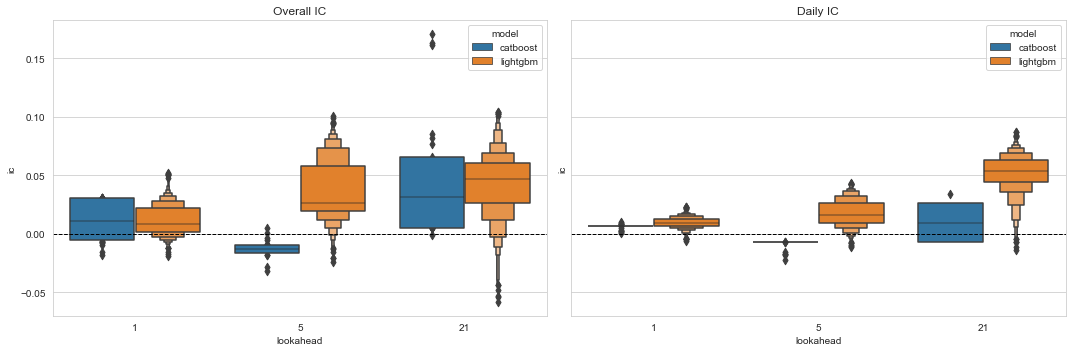

In [25]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 5), sharey=True)
sns.boxenplot(x='lookahead', y='ic', hue='model',
              data=catboost_metrics.assign(model='catboost')
              .append(lgb_metrics.assign(model='lightgbm')), ax=axes[0])
axes[0].axhline(0, ls='--', lw=1, c='k')
axes[0].set_title('Overall IC')
sns.boxenplot(x='lookahead', y='ic', hue='model',
              data=catboost_daily_ic.assign(model='catboost')
              .append(lgb_daily_ic.assign(model='lightgbm')), ax=axes[1])
axes[1].axhline(0, ls='--', lw=1, c='k')
axes[1].set_title('Daily IC')
fig.tight_layout()

## HyperParameter Impact: Linear Regression

Next, we'd like to understand if there's a systematic, statistical relationship between the hyperparameters and the outcomes across daily predictions. To this end, we will run a linear regression using the various LightGBM hyperparameter settings as dummy variables and the daily validation IC as the outcome.

The below chart shows the coefficient estimates and their confidence intervals for 1- and 21-day forecast horizons. 
- For the shorter horizon, a longer lookback period, a higher learning rate, and deeper trees (more leaf nodes) have a positive impact. 
- For the longer horizon, the picture is a little less clear: shorter trees do better, but the lookback period is not significant. A higher feature sampling rate also helps. In both cases, a larger ensemble does better. 

Note that these results apply to this specific example only.

In [26]:
lin_reg = {}
for t in [1, 21]:
    df_ = lgb_ic[lgb_ic.lookahead==t]
    y, X = df_.ic, df_.drop(['ic'], axis=1)
    X = sm.add_constant(pd.get_dummies(X, columns=X.columns, drop_first=True))
    model = sm.OLS(endog=y, exog=X)
    lin_reg[t] = model.fit()
    s = lin_reg[t].summary()
    coefs = pd.read_csv(StringIO(s.tables[1].as_csv())).rename(columns=lambda x: x.strip())
    coefs.columns = ['variable', 'coef', 'std_err', 't', 'p_value', 'ci_low', 'ci_high']
    coefs.to_csv(f'results/linreg_result_{t:02}.csv', index=False)

In [27]:
def visualize_lr_result(model, ax):
    ci = model.conf_int()
    errors = ci[1].sub(ci[0]).div(2)

    coefs = (model.params.to_frame('coef').assign(error=errors)
             .reset_index().rename(columns={'index': 'variable'}))
    coefs = coefs[~coefs['variable'].str.startswith('date')&(coefs.variable!='const')]

    coefs.plot(x='variable', y='coef', kind='bar', 
                 ax=ax, color='none', capsize=3,
                 yerr='error', legend=False)
    ax.set_ylabel('IC')
    ax.set_xlabel('')
    ax.scatter(x=pd.np.arange(len(coefs)), marker='_', s=120, y=coefs['coef'], color='black')
    ax.axhline(y=0, linestyle='--', color='black', linewidth=1)
    ax.xaxis.set_ticks_position('none')

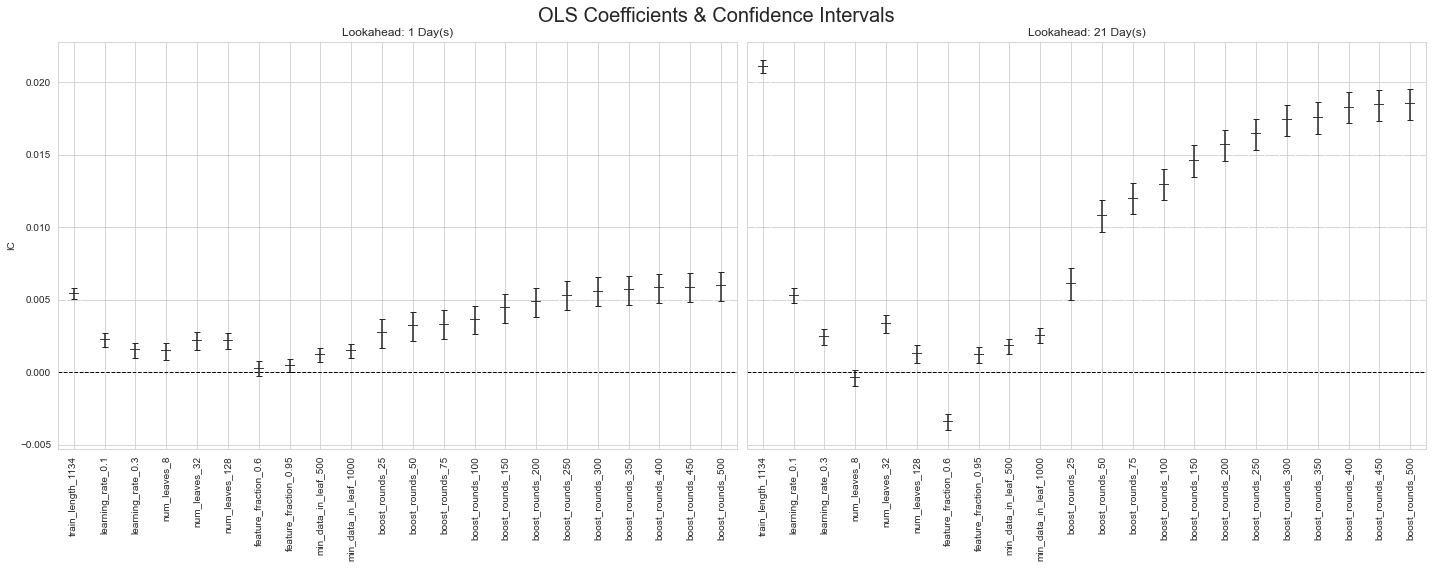

In [28]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8), sharey=True)
axes = axes.flatten()
for i, t in enumerate([1, 21]):
    visualize_lr_result(lin_reg[t], axes[i])
    axes[i].set_title(f'Lookahead: {t} Day(s)')
fig.suptitle('OLS Coefficients & Confidence Intervals', fontsize=20)
fig.tight_layout()
fig.subplots_adjust(top=.92);

## Cross-validation Result: Best Hyperparameters

### LightGBM

The top-performing LightGBM models use the following parameters for the three different prediction horizons.

In [29]:
group_cols = scope_params + lgb_train_params + ['boost_rounds']
lgb_daily_ic.groupby('lookahead', group_keys=False).apply(lambda x: x.nlargest(3, 'ic'))

,lookahead,train_length,test_length,learning_rate,num_leaves,feature_fraction,min_data_in_leaf,boost_rounds,ic
1025,1,1134,63,0.01,128,0.95,500,450,0.022939
1026,1,1134,63,0.01,128,0.95,500,500,0.022861
1024,1,1134,63,0.01,128,0.95,500,400,0.022538
2478,5,1134,63,0.10,4,0.60,250,300,0.042987
2544,5,1134,63,0.10,8,0.60,250,350,0.042899
2479,5,1134,63,0.10,4,0.60,250,350,0.042331
3983,21,1134,63,0.10,4,0.30,250,150,0.087104
3996,21,1134,63,0.10,4,0.30,500,150,0.086613
3982,21,1134,63,0.10,4,0.30,250,100,0.084657


In [30]:
lgb_metrics.groupby('lookahead', group_keys=False).apply(lambda x: x.nlargest(3, 'ic'))
lgb_metrics.groupby('lookahead', group_keys=False).apply(lambda x: x.nlargest(3, 'ic')).to_csv('results/best_lgb_model.csv', index=False)

In [31]:
lgb_metrics.groupby('lookahead', group_keys=False).apply(lambda x: x.nlargest(3, 'daily_ic_mean'))

,lookahead,train_length,test_length,learning_rate,num_leaves,feature_fraction,min_data_in_leaf,daily_ic_mean,daily_ic_mean_n,daily_ic_median,daily_ic_median_n,boost_rounds,ic
338,1,1134,63,0.01,128.0,0.95,500.0,0.022939,450.0,0.021692,500.0,10,-0.002507
681,1,1134,63,0.01,128.0,0.95,500.0,0.022939,450.0,0.021692,500.0,25,0.009275
1024,1,1134,63,0.01,128.0,0.95,500.0,0.022939,450.0,0.021692,500.0,50,0.000329
85,5,1134,63,0.10,4.0,0.60,250.0,0.042987,300.0,0.039473,500.0,10,0.024042
428,5,1134,63,0.10,4.0,0.60,250.0,0.042987,300.0,0.039473,500.0,25,0.022303
771,5,1134,63,0.10,4.0,0.60,250.0,0.042987,300.0,0.039473,500.0,50,0.034456
199,21,1134,63,0.10,4.0,0.30,250.0,0.087104,150.0,0.099521,150.0,10,0.073508
542,21,1134,63,0.10,4.0,0.30,250.0,0.087104,150.0,0.099521,150.0,25,0.071501
885,21,1134,63,0.10,4.0,0.30,250.0,0.087104,150.0,0.099521,150.0,50,0.073783


### CatBoost

In [32]:
group_cols = scope_params + catboost_train_params + ['boost_rounds']
catboost_daily_ic.groupby('lookahead', group_keys=False).apply(lambda x: x.nlargest(3, 'ic'))

,lookahead,train_length,test_length,max_depth,min_child_samples,boost_rounds,ic
0,1,252,63,7,250,10,0.009737
2,1,252,63,7,250,50,0.009169
1,1,252,63,7,250,25,0.008501
53,5,1134,63,9,250,800,-0.007209
54,5,1134,63,9,250,900,-0.007209
55,5,1134,63,9,250,1000,-0.007209
70,21,1134,63,7,250,10,0.034379
71,21,1134,63,7,250,25,0.026409
72,21,1134,63,7,250,50,0.026409


In [33]:
catboost_metrics.groupby('lookahead', group_keys=False).apply(lambda x: x.nlargest(3, 'ic'))

,lookahead,train_length,test_length,max_depth,min_child_samples,daily_ic_mean,daily_ic_mean_n,daily_ic_median,daily_ic_median_n,boost_rounds,ic
58,1,252,63,7.0,250.0,0.009737,10.0,0.007969,25.0,600,0.030559
64,1,252,63,7.0,250.0,0.009737,10.0,0.007969,25.0,700,0.030553
52,1,252,63,7.0,250.0,0.009737,10.0,0.007969,25.0,500,0.030552
0,5,252,63,3.0,500.0,-0.007421,10.0,-0.001583,10.0,10,0.005064
25,5,1134,63,9.0,250.0,-0.007209,800.0,-0.000443,300.0,100,0.000965
6,5,252,63,3.0,500.0,-0.007421,10.0,-0.001583,10.0,25,-0.003535
15,21,1134,63,7.0,250.0,0.034379,10.0,0.026840,25.0,50,0.170919
21,21,1134,63,7.0,250.0,0.034379,10.0,0.026840,25.0,75,0.162658
27,21,1134,63,7.0,250.0,0.034379,10.0,0.026840,25.0,100,0.161264


In [34]:
catboost_metrics.groupby('lookahead', group_keys=False).apply(lambda x: x.nlargest(3, 'daily_ic_mean'))

,lookahead,train_length,test_length,max_depth,min_child_samples,daily_ic_mean,daily_ic_mean_n,daily_ic_median,daily_ic_median_n,boost_rounds,ic
4,1,252,63,7.0,250.0,0.009737,10.0,0.007969,25.0,10,0.027296
10,1,252,63,7.0,250.0,0.009737,10.0,0.007969,25.0,25,0.029649
16,1,252,63,7.0,250.0,0.009737,10.0,0.007969,25.0,50,0.029368
1,5,1134,63,9.0,250.0,-0.007209,800.0,-0.000443,300.0,10,-0.028216
7,5,1134,63,9.0,250.0,-0.007209,800.0,-0.000443,300.0,25,-0.032009
13,5,1134,63,9.0,250.0,-0.007209,800.0,-0.000443,300.0,50,-0.014222
3,21,1134,63,7.0,250.0,0.034379,10.0,0.026840,25.0,10,0.039863
9,21,1134,63,7.0,250.0,0.034379,10.0,0.026840,25.0,25,0.076738
15,21,1134,63,7.0,250.0,0.034379,10.0,0.026840,25.0,50,0.170919


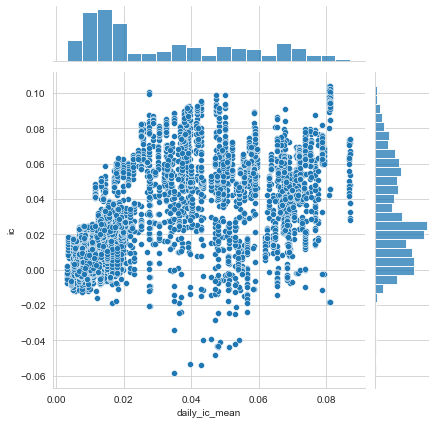

In [35]:
sns.jointplot(x=lgb_metrics.daily_ic_mean,y=lgb_metrics.ic);

### Visualization

#### LightGBM

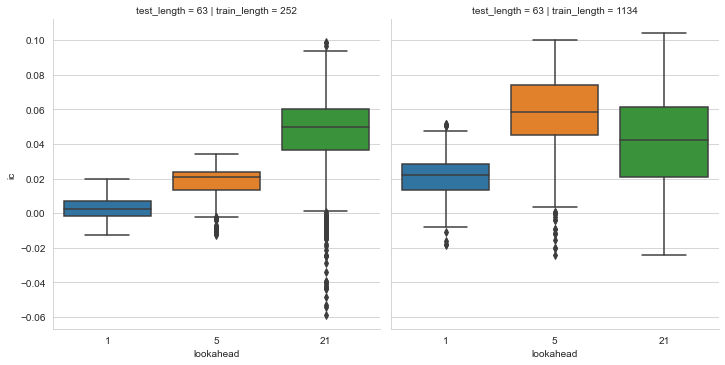

In [36]:
g = sns.catplot(x='lookahead', y='ic',
                col='train_length', row='test_length',
                data=lgb_metrics,
                kind='box')

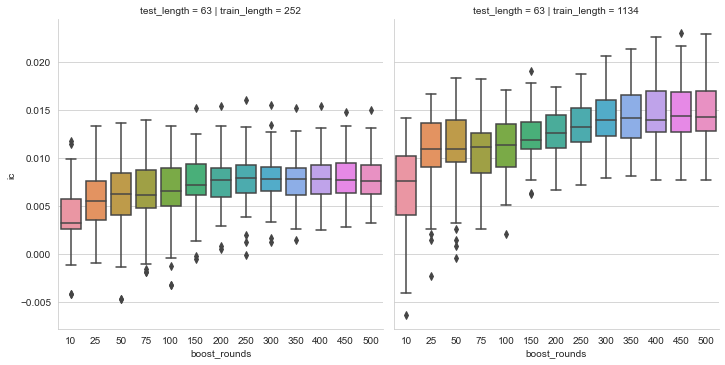

In [37]:
t=1
g=sns.catplot(x='boost_rounds',
            y='ic',
            col='train_length',
            row='test_length',
            data=lgb_daily_ic[lgb_daily_ic.lookahead == t],
            kind='box')

#### CatBoost

Some figures are empty because we did not run those parameter combinations.

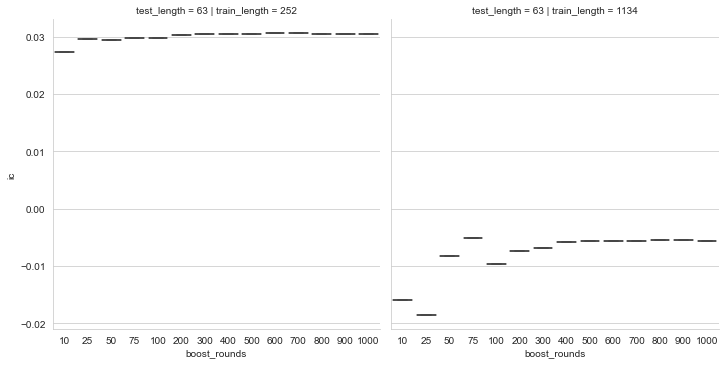

In [38]:
t = 1
g=sns.catplot(x='boost_rounds',
            y='ic',
            col='train_length',
            row='test_length',
            data=catboost_metrics[catboost_metrics.lookahead == t],
            kind='box')

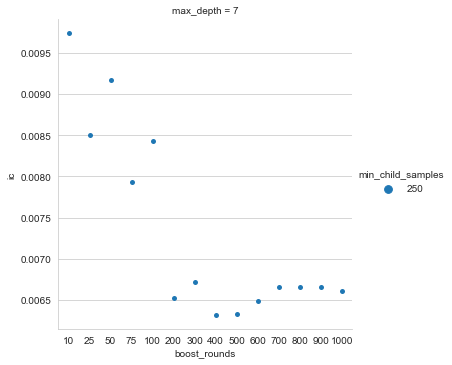

In [39]:
t = 1
train_length = 252
test_length = 63
g = sns.catplot(
    x='boost_rounds',
    y='ic',
    col='max_depth',
    hue='min_child_samples',
    data=catboost_daily_ic[(catboost_daily_ic.lookahead == t) &
                      (catboost_daily_ic.train_length == train_length) &
                      (catboost_daily_ic.test_length == test_length)],
    kind='swarm')

## AlphaLens Analysis - Validation Performance

### LightGBM

#### Select Parameters

In [40]:
lgb_daily_ic = pd.read_hdf('data/model_tuning.h5', 'lgb/daily_ic')
lgb_daily_ic.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4459 entries, 0 to 4458
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   lookahead         4459 non-null   int64  
 1   train_length      4459 non-null   int64  
 2   test_length       4459 non-null   int64  
 3   learning_rate     4459 non-null   float64
 4   num_leaves        4459 non-null   int64  
 5   feature_fraction  4459 non-null   float64
 6   min_data_in_leaf  4459 non-null   int64  
 7   boost_rounds      4459 non-null   int64  
 8   ic                4459 non-null   float64
dtypes: float64(3), int64(6)
memory usage: 348.4 KB


In [41]:
def get_lgb_params(data, t=5, best=0):
    param_cols = scope_params[1:] + lgb_train_params + ['boost_rounds']
    df = data[data.lookahead==t].sort_values('ic', ascending=False).iloc[best]
    return df.loc[param_cols]

In [42]:
def get_lgb_key(t, p):
    key = f'{t}/{int(p.train_length)}/{int(p.test_length)}/{p.learning_rate}/'
    return key + f'{int(p.num_leaves)}/{p.feature_fraction}/{int(p.min_data_in_leaf)}'

In [43]:
best_params = get_lgb_params(lgb_daily_ic, t=1, best=0)
best_params

train_length        1134.00
test_length           63.00
learning_rate          0.01
num_leaves           128.00
feature_fraction       0.95
min_data_in_leaf     500.00
boost_rounds         450.00
Name: 1025, dtype: float64

In [44]:
best_params.to_hdf('data.h5', 'best_params')

#### Plot rolling IC

In [45]:
def select_ic(params, ic_data, lookahead):
    return ic_data.loc[(ic_data.lookahead == lookahead) &
                       (ic_data.train_length == params.train_length) &
                       (ic_data.test_length == params.test_length) &
                       (ic_data.learning_rate == params.learning_rate) &
                       (ic_data.num_leaves == params.num_leaves) &
                       (ic_data.feature_fraction == params.feature_fraction) &
                       (ic_data.boost_rounds == params.boost_rounds), ['date', 'ic']].set_index('date')

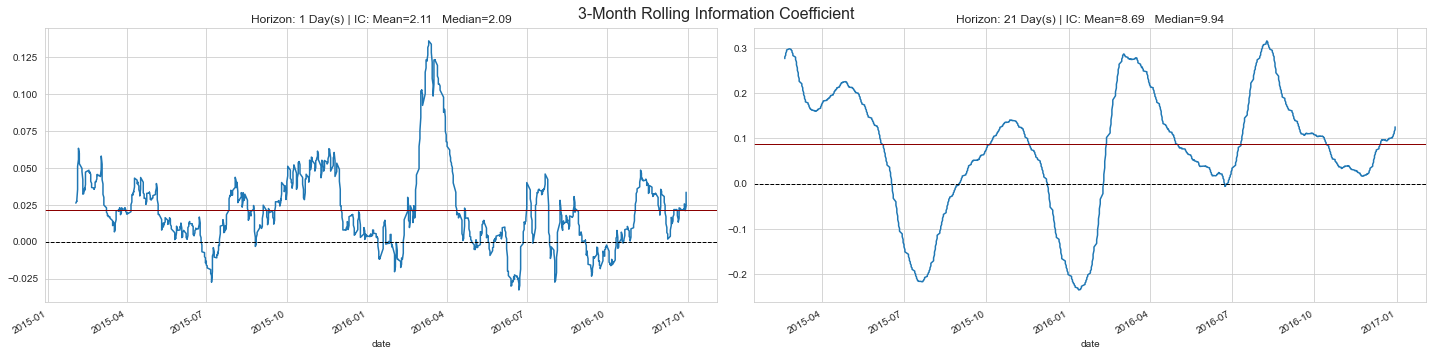

In [46]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
axes = axes.flatten()
for i, t in enumerate([1, 21]):
    params = get_lgb_params(lgb_daily_ic, t=t)
    data = select_ic(params, lgb_ic, lookahead=t).sort_index()
    rolling = data.rolling(63).ic.mean().dropna()
    avg = data.ic.mean()
    med = data.ic.median()
    rolling.plot(ax=axes[i], title=f'Horizon: {t} Day(s) | IC: Mean={avg*100:.2f}   Median={med*100:.2f}')
    axes[i].axhline(avg, c='darkred', lw=1)
    axes[i].axhline(0, ls='--', c='k', lw=1)

fig.suptitle('3-Month Rolling Information Coefficient', fontsize=16)
fig.tight_layout()
fig.subplots_adjust(top=0.92);

#### Get Predictions for Validation Period

We retrieve the predictions for the 10 validation runs:

In [47]:
lookahead = 1
topn = 10
for best in range(topn):
    best_params = get_lgb_params(lgb_daily_ic, t=lookahead, best=best)
    key = get_lgb_key(lookahead, best_params)
    rounds = str(int(best_params.boost_rounds))
    if best == 0:
        best_predictions = pd.read_hdf(results_path / 'tuning_lgb.h5', 'predictions/' + key)
        best_predictions = best_predictions[rounds].to_frame(best)
    else:
        best_predictions[best] = pd.read_hdf(results_path / 'tuning_lgb.h5',
                                             'predictions/' + key)[rounds]
best_predictions = best_predictions.sort_index()

In [48]:
best_predictions.to_hdf('data/predictions.h5', f'lgb/train/{lookahead:02}')
best_predictions.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 500822 entries, ('A', Timestamp('2015-01-02 00:00:00')) to ('UDR', Timestamp('2016-12-30 00:00:00'))
Data columns (total 10 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       500822 non-null  float64
 1   1       500822 non-null  float64
 2   2       500822 non-null  float64
 3   3       500822 non-null  float64
 4   4       500822 non-null  float64
 5   5       500822 non-null  float64
 6   6       500822 non-null  float64
 7   7       500822 non-null  float64
 8   8       500822 non-null  float64
 9   9       500822 non-null  float64
dtypes: float64(10)
memory usage: 40.2+ MB


#### Get Trade Prices

Using next available prices.

In [49]:
def get_trade_prices(tickers):
    idx = pd.IndexSlice
    DATA_STORE = '../data/assets.h5'
    prices = (pd.read_hdf(DATA_STORE, 'quandl/wiki/prices').swaplevel().sort_index())
    prices.index.names = ['symbol', 'date']
    return (prices.loc[idx[tickers, '2015': '2017'], 'adj_open']
            .unstack('symbol')
            .sort_index()
            .shift(-1)
            .tz_localize('UTC'))

In [50]:
test_tickers = best_predictions.index.get_level_values('symbol').unique()

In [51]:
trade_prices = get_trade_prices(test_tickers)
trade_prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 755 entries, 2015-01-02 00:00:00+00:00 to 2017-12-29 00:00:00+00:00
Columns: 994 entries, A to UDR
dtypes: float64(994)
memory usage: 5.7 MB


In [52]:
# persist result in case we want to rerun:
trade_prices.to_hdf('data/model_tuning.h5', 'trade_prices/model_selection')
trade_prices = pd.read_hdf('data/model_tuning.h5', 'trade_prices/model_selection')

We average the top five models and provide the corresponding prices to Alphalens, in order to compute the mean period-wise return earned on an equal-weighted portfolio invested in the daily factor quintiles for various holding periods:

In [53]:
factor = best_predictions.iloc[:, :5].mean(1).dropna().tz_localize('UTC', level='date').swaplevel()

#### Create AlphaLens Inputs

In [54]:
factor_data = get_clean_factor_and_forward_returns(factor=factor,
                                                   prices=trade_prices,
                                                   quantiles=5,
                                                   periods=(1, 5, 10, 21))

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


#### Compute Alphalens metrics

In [55]:
mean_quant_ret_bydate, std_quant_daily = perf.mean_return_by_quantile(
    factor_data,
    by_date=True,
    by_group=False,
    demeaned=True,
    group_adjust=False,
)

In [56]:
factor_returns = perf.factor_returns(factor_data)

In [57]:
mean_quant_ret, std_quantile = perf.mean_return_by_quantile(factor_data,
                                                            by_group=False,
                                                            demeaned=True)



mean_quant_rateret = mean_quant_ret.apply(rate_of_return, axis=0,
                                          base_period=mean_quant_ret.columns[0])

In [58]:
mean_quant_ret_bydate, std_quant_daily = perf.mean_return_by_quantile(
    factor_data,
    by_date=True,
    by_group=False,
    demeaned=True,
    group_adjust=False,
)

mean_quant_rateret_bydate = mean_quant_ret_bydate.apply(
    rate_of_return,
    base_period=mean_quant_ret_bydate.columns[0],
)

compstd_quant_daily = std_quant_daily.apply(std_conversion,
                                            base_period=std_quant_daily.columns[0])

alpha_beta = perf.factor_alpha_beta(factor_data,
                                    demeaned=True)

mean_ret_spread_quant, std_spread_quant = perf.compute_mean_returns_spread(
    mean_quant_rateret_bydate,
    factor_data["factor_quantile"].max(),
    factor_data["factor_quantile"].min(),
    std_err=compstd_quant_daily,
)

In [59]:
mean_ret_spread_quant.mean().mul(10000).to_frame('Mean Period Wise Spread (bps)').join(alpha_beta.T).T

,1D,5D,10D,21D
Mean Period Wise Spread (bps),11.632096,6.212951,4.858332,4.559032
Ann. alpha,0.146008,0.054395,0.035422,0.035967
beta,0.090324,0.155857,0.186271,0.185263


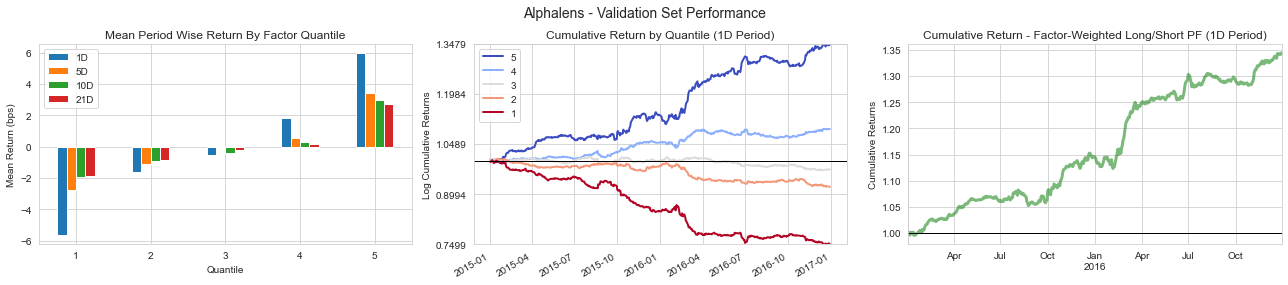

In [60]:
fig, axes = plt.subplots(ncols=3, figsize=(18, 4))


plotting.plot_quantile_returns_bar(mean_quant_rateret, ax=axes[0])
plt.setp(axes[0].xaxis.get_majorticklabels(), rotation=0)
axes[0].set_xlabel('Quantile')

plotting.plot_cumulative_returns_by_quantile(mean_quant_ret_bydate['1D'],
                                             freq=pd.tseries.offsets.BDay(),
                                             period='1D',
                                             ax=axes[1])
axes[1].set_title('Cumulative Return by Quantile (1D Period)')

title = "Cumulative Return - Factor-Weighted Long/Short PF (1D Period)"
plotting.plot_cumulative_returns(factor_returns['1D'],
                                 period='1D',
                                 freq=pd.tseries.offsets.BDay(),
                                 title=title,
                                 ax=axes[2])

fig.suptitle('Alphalens - Validation Set Performance', fontsize=14)
fig.tight_layout()
fig.subplots_adjust(top=.85);

#### Summary Tearsheet

Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,-0.039255,0.007344,-0.001889,0.003216,100296,20.026277
2,-0.011305,0.009462,-0.000633,0.002908,100184,20.003914
3,-0.010267,0.011313,0.000066,0.002932,99863,19.939819
4,-0.009399,0.017518,0.000738,0.003034,100184,20.003914
5,-0.008400,0.058980,0.002107,0.003695,100295,20.026077


Returns Analysis


,1D,5D,10D,21D
Ann. alpha,0.146,0.054,0.035,0.036
beta,0.090,0.156,0.186,0.185
Mean Period Wise Return Top Quantile (bps),5.981,3.438,2.956,2.723
Mean Period Wise Return Bottom Quantile (bps),-5.651,-2.788,-1.920,-1.855
Mean Period Wise Spread (bps),11.632,6.213,4.858,4.559


Information Analysis


,1D,5D,10D,21D
IC Mean,0.018,0.019,0.019,0.035
IC Std.,0.117,0.130,0.135,0.135
Risk-Adjusted IC,0.153,0.147,0.143,0.262
t-stat(IC),3.427,3.304,3.201,5.877
p-value(IC),0.001,0.001,0.001,0.000
IC Skew,-0.100,0.110,0.124,0.108
IC Kurtosis,1.221,1.873,0.873,0.681


Turnover Analysis


,1D,5D,10D,21D
Quantile 1 Mean Turnover,0.630,0.660,0.724,0.770
Quantile 2 Mean Turnover,0.756,0.762,0.779,0.791
Quantile 3 Mean Turnover,0.769,0.772,0.784,0.791
Quantile 4 Mean Turnover,0.755,0.761,0.780,0.791
Quantile 5 Mean Turnover,0.621,0.650,0.701,0.736


,1D,5D,10D,21D
Mean Factor Rank Autocorrelation,0.316,0.263,0.151,0.075


<Figure size 432x288 with 0 Axes>

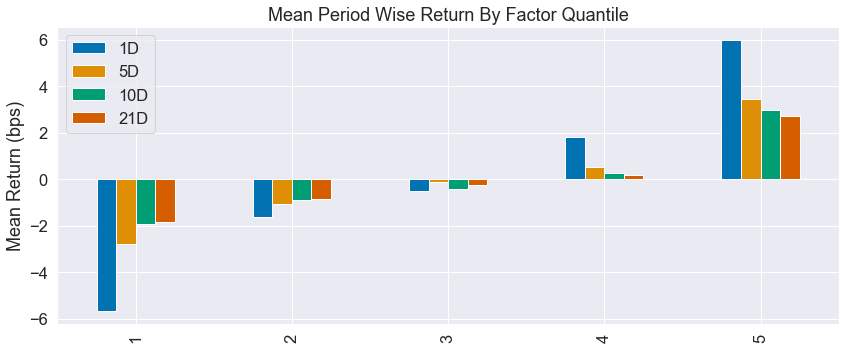

In [61]:
create_summary_tear_sheet(factor_data)

Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,-0.039255,0.007344,-0.001889,0.003216,100296,20.026277
2,-0.011305,0.009462,-0.000633,0.002908,100184,20.003914
3,-0.010267,0.011313,0.000066,0.002932,99863,19.939819
4,-0.009399,0.017518,0.000738,0.003034,100184,20.003914
5,-0.008400,0.058980,0.002107,0.003695,100295,20.026077


Returns Analysis


,1D,5D,10D,21D
Ann. alpha,0.146,0.054,0.035,0.036
beta,0.090,0.156,0.186,0.185
Mean Period Wise Return Top Quantile (bps),5.981,3.438,2.956,2.723
Mean Period Wise Return Bottom Quantile (bps),-5.651,-2.788,-1.920,-1.855
Mean Period Wise Spread (bps),11.632,6.213,4.858,4.559


<Figure size 432x288 with 0 Axes>

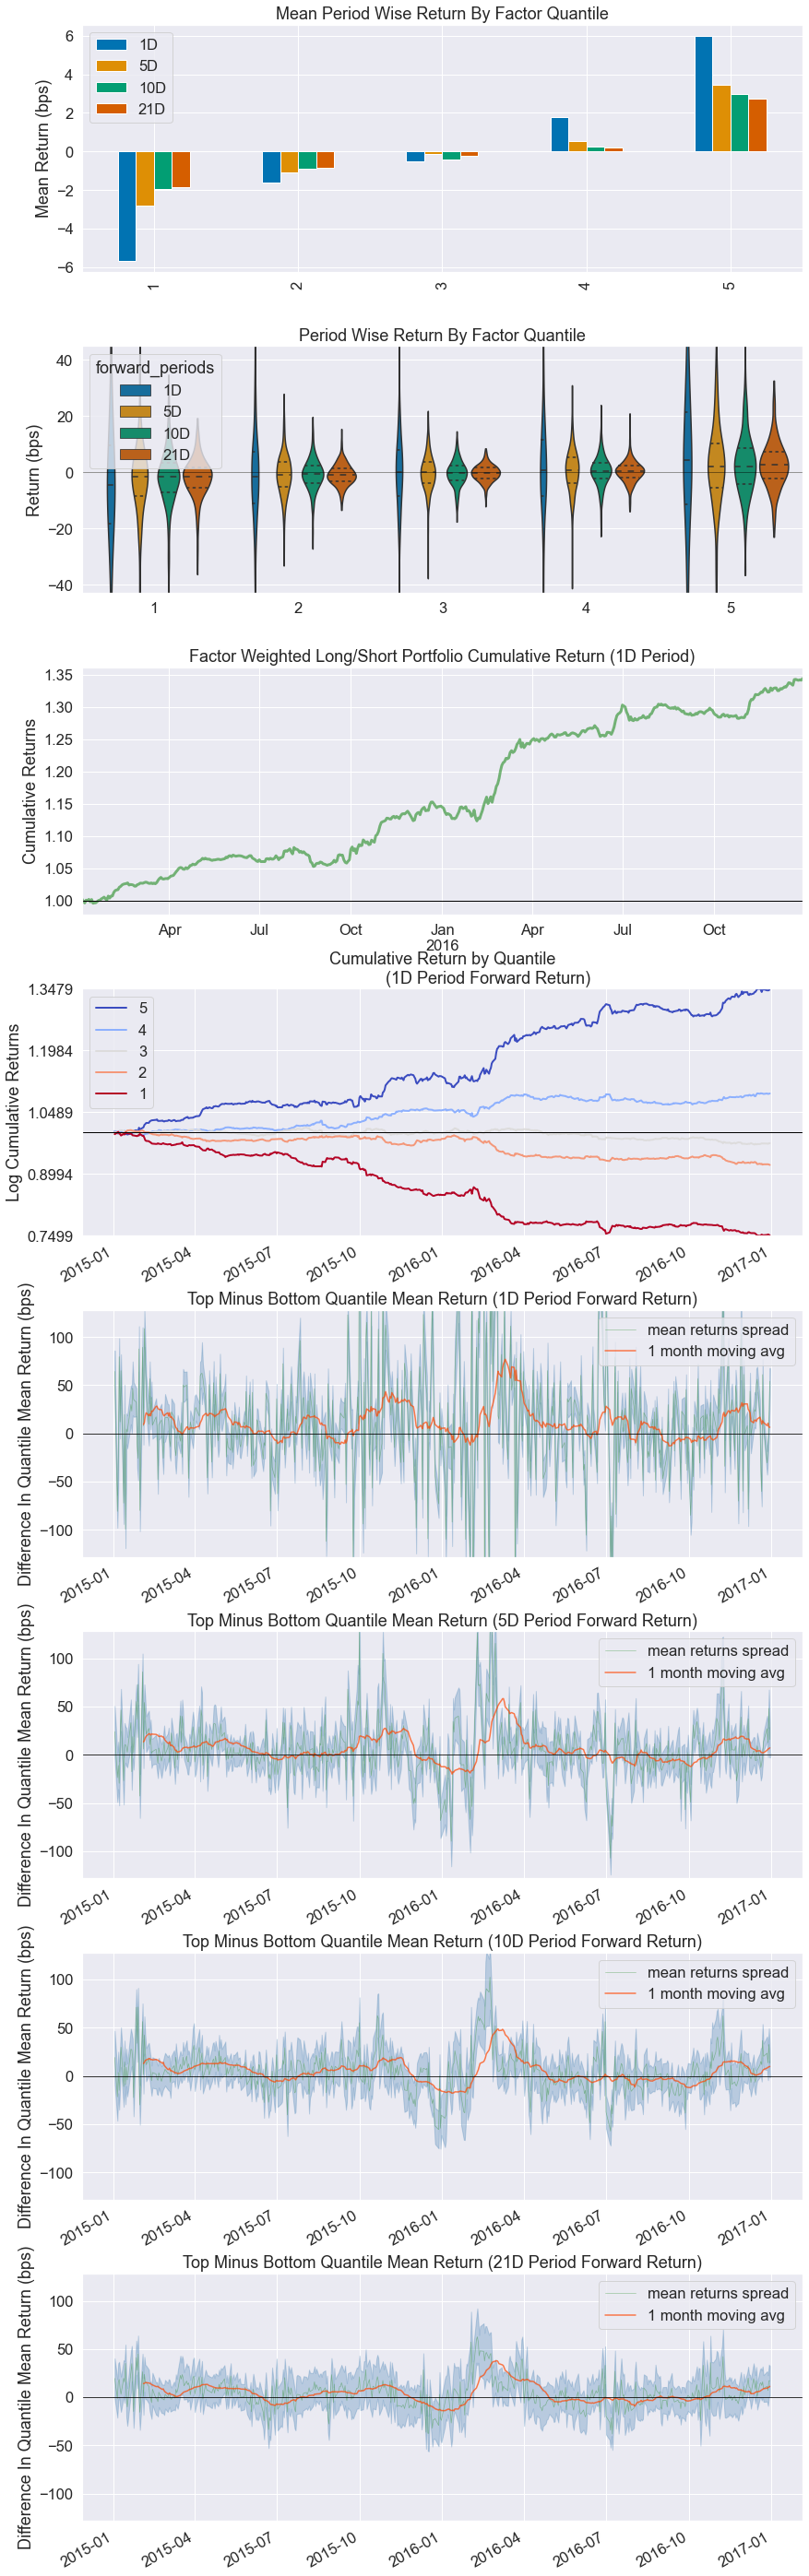

Information Analysis


,1D,5D,10D,21D
IC Mean,0.018,0.019,0.019,0.035
IC Std.,0.117,0.130,0.135,0.135
Risk-Adjusted IC,0.153,0.147,0.143,0.262
t-stat(IC),3.427,3.304,3.201,5.877
p-value(IC),0.001,0.001,0.001,0.000
IC Skew,-0.100,0.110,0.124,0.108
IC Kurtosis,1.221,1.873,0.873,0.681


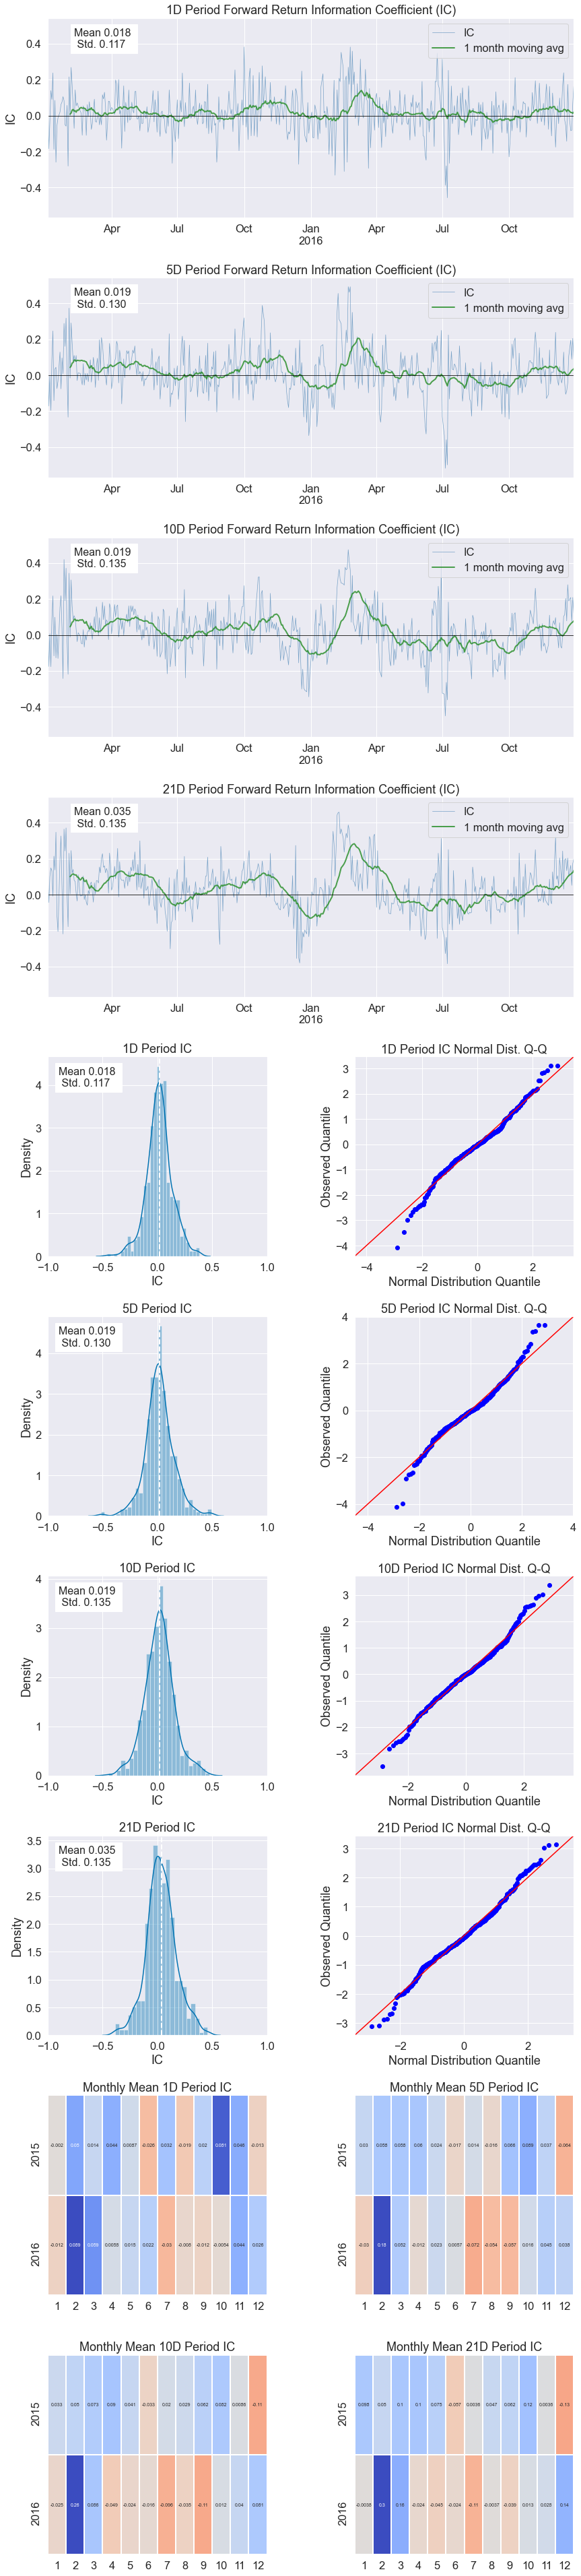

Turnover Analysis


,1D,5D,10D,21D
Quantile 1 Mean Turnover,0.630,0.660,0.724,0.770
Quantile 2 Mean Turnover,0.756,0.762,0.779,0.791
Quantile 3 Mean Turnover,0.769,0.772,0.784,0.791
Quantile 4 Mean Turnover,0.755,0.761,0.780,0.791
Quantile 5 Mean Turnover,0.621,0.650,0.701,0.736


,1D,5D,10D,21D
Mean Factor Rank Autocorrelation,0.316,0.263,0.151,0.075


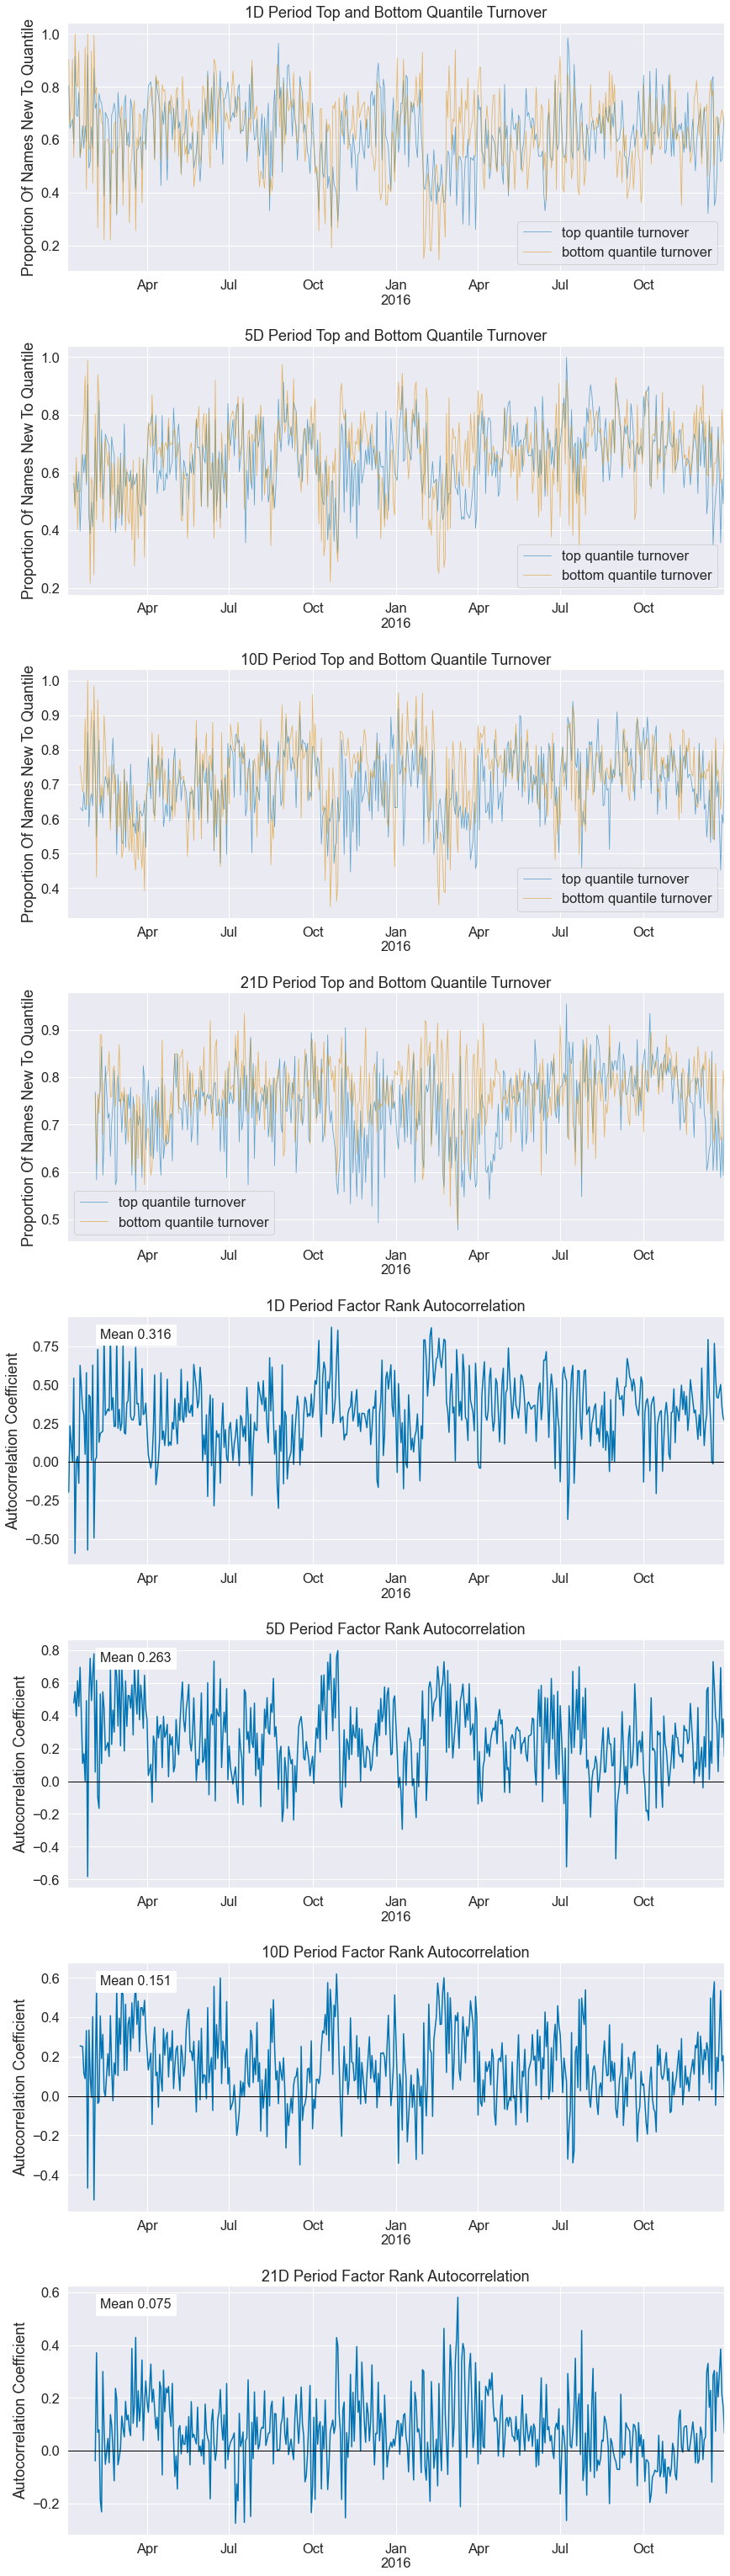

In [62]:
create_full_tear_sheet(factor_data)

### CatBoost

#### Select Parameters

In [63]:
catboost_daily_ic = pd.read_hdf('data/model_tuning.h5', 'catboost/daily_ic')
catboost_daily_ic.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 84 entries, 0 to 83
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   lookahead          84 non-null     int64  
 1   train_length       84 non-null     int64  
 2   test_length        84 non-null     int64  
 3   max_depth          84 non-null     int64  
 4   min_child_samples  84 non-null     int64  
 5   boost_rounds       84 non-null     int64  
 6   ic                 84 non-null     float64
dtypes: float64(1), int64(6)
memory usage: 5.2 KB


In [64]:
def get_cb_params(data, t=5, best=0):
    param_cols = scope_params[1:] + catboost_train_params + ['boost_rounds']
    df = data[data.lookahead==t].sort_values('ic', ascending=False).iloc[best]
    return df.loc[param_cols]

In [65]:
def get_cb_key(t, p):
    key = f'{t}/{int(p.train_length)}/{int(p.test_length)}/'
    return key + f'{int(p.max_depth)}/{int(p.min_child_samples)}'

In [66]:
best_params = get_cb_params(catboost_daily_ic, t=1, best=0)
best_params

train_length         252.0
test_length           63.0
max_depth              7.0
min_child_samples    250.0
boost_rounds          10.0
Name: 0, dtype: float64

In [67]:
def select_cb_ic(params, ic_data, lookahead):
    return ic_data.loc[(ic_data.lookahead == lookahead) &
                       (ic_data.train_length == params.train_length) &
                       (ic_data.test_length == params.test_length) &
                       (ic_data.max_depth == params.max_depth) &
                       (ic_data.min_child_samples == params.min_child_samples)].set_index('date')

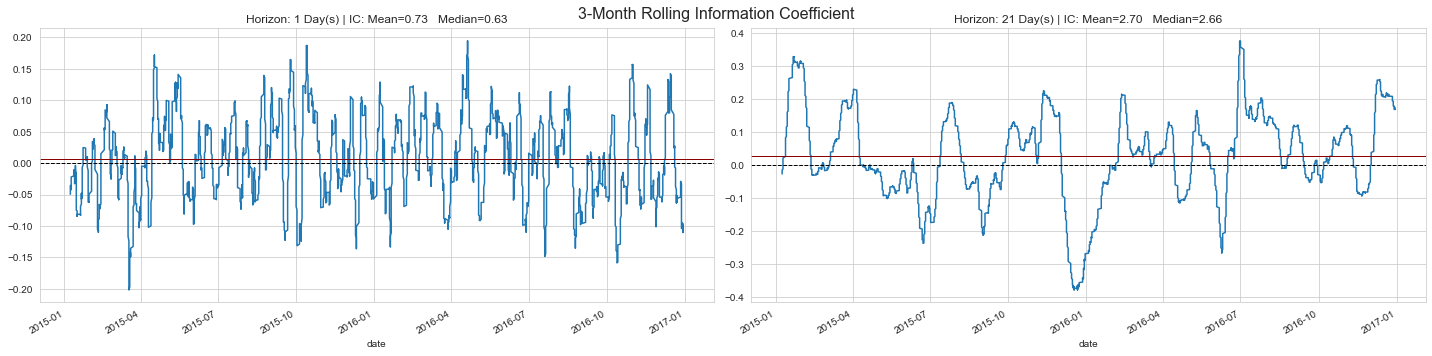

In [68]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
axes = axes.flatten()
for i, t in enumerate([1, 21]):
    params = get_cb_params(catboost_daily_ic, t=t)
    data = select_cb_ic(params, catboost_ic, lookahead=t).sort_index()
    rolling = data.rolling(63).ic.mean().dropna()
    avg = data.ic.mean()
    med = data.ic.median()
    rolling.plot(ax=axes[i], title=f'Horizon: {t} Day(s) | IC: Mean={avg*100:.2f}   Median={med*100:.2f}')
    axes[i].axhline(avg, c='darkred', lw=1)
    axes[i].axhline(0, ls='--', c='k', lw=1)

fig.suptitle('3-Month Rolling Information Coefficient', fontsize=16)
fig.tight_layout()
fig.subplots_adjust(top=0.92);

#### Get Predictions

In [76]:
lookahead = 1
topn = 10
for best in range(topn):
    best_params = get_cb_params(catboost_daily_ic, t=lookahead, best=best)
    key = get_cb_key(lookahead, best_params)
    # 파일 못읽는 문제 해결으리 위해 실행
    key = "1/252/63"
    rounds = str(int(best_params.boost_rounds))
    if best == 0:
        best_predictions = pd.read_hdf(results_path / 'tuning_catboost.h5', 'predictions/' + key)
        best_predictions = best_predictions[rounds].to_frame(best)
    else:
        best_predictions[best] = pd.read_hdf(results_path / 'tuning_catboost.h5',
                                             'predictions/' + key)[rounds]
best_predictions = best_predictions.sort_index()

In [77]:
best_predictions.to_hdf('data/predictions.h5', f'catboost/train/{lookahead:02}')
best_predictions.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 500317 entries, ('A', Timestamp('2015-01-02 00:00:00')) to ('UDR', Timestamp('2016-12-30 00:00:00'))
Data columns (total 10 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       500317 non-null  float64
 1   1       500317 non-null  float64
 2   2       500317 non-null  float64
 3   3       500317 non-null  float64
 4   4       500317 non-null  float64
 5   5       500317 non-null  float64
 6   6       500317 non-null  float64
 7   7       500317 non-null  float64
 8   8       500317 non-null  float64
 9   9       500317 non-null  float64
dtypes: float64(10)
memory usage: 40.1+ MB


#### Get Trade Prices

Using next available prices.

In [78]:
def get_trade_prices(tickers):
    idx = pd.IndexSlice
    DATA_STORE = '../data/assets.h5'
    prices = (pd.read_hdf(DATA_STORE, 'quandl/wiki/prices').swaplevel().sort_index())
    prices.index.names = ['symbol', 'date']
    return (prices.loc[idx[tickers, '2015': '2017'], 'adj_open']
            .unstack('symbol')
            .sort_index()
            .shift(-1)
            .tz_localize('UTC'))

In [79]:
test_tickers = best_predictions.index.get_level_values('symbol').unique()

In [80]:
trade_prices = get_trade_prices(test_tickers)
trade_prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 755 entries, 2015-01-02 00:00:00+00:00 to 2017-12-29 00:00:00+00:00
Columns: 993 entries, A to UDR
dtypes: float64(993)
memory usage: 5.7 MB


In [81]:
# only generate once to save time
trade_prices.to_hdf('data/model_tuning.h5', 'trade_prices/model_selection')

In [82]:
trade_prices = pd.read_hdf('data/model_tuning.h5', 'trade_prices/model_selection')

In [83]:
factor = best_predictions.iloc[:, :5].mean(1).dropna().tz_localize('UTC', level='date').swaplevel()

#### Create AlphaLens Inputs

In [84]:
factor_data = get_clean_factor_and_forward_returns(factor=factor,
                                                   prices=trade_prices,
                                                   quantiles=5,
                                                   periods=(1, 5, 10, 21))

Dropped 4.2% entries from factor data: 0.0% in forward returns computation and 4.2% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


#### Summary Tearsheet

Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1.0,-0.023959,0.006472,-0.001851,0.003880,119440,24.910839
2.0,-0.010193,0.006973,-0.000524,0.003474,102027,21.279121
3.0,-0.008058,0.009507,0.000571,0.003424,97041,20.239222
4.0,-0.007587,0.010891,0.001109,0.003373,95720,19.963710
5.0,-0.005888,0.018711,0.002918,0.003375,65242,13.607108


Returns Analysis


,1D,5D,10D,21D
Ann. alpha,0.050,0.017,0.007,-0.001
beta,-0.046,-0.039,-0.006,-0.014
Mean Period Wise Return Top Quantile (bps),3.525,0.410,-0.171,-0.958
Mean Period Wise Return Bottom Quantile (bps),-2.318,-0.317,-0.254,-0.379
Mean Period Wise Spread (bps),5.843,0.646,-0.023,-0.704


Information Analysis


,1D,5D,10D,21D
IC Mean,0.012,0.004,0.000,-0.005
IC Std.,0.145,0.151,0.155,0.149
Risk-Adjusted IC,0.083,0.027,0.003,-0.035
t-stat(IC),NaN,NaN,NaN,NaN
p-value(IC),NaN,NaN,NaN,NaN
IC Skew,NaN,NaN,NaN,NaN
IC Kurtosis,NaN,NaN,NaN,NaN


TypeError: object of type 'float' has no len()

<Figure size 432x288 with 0 Axes>

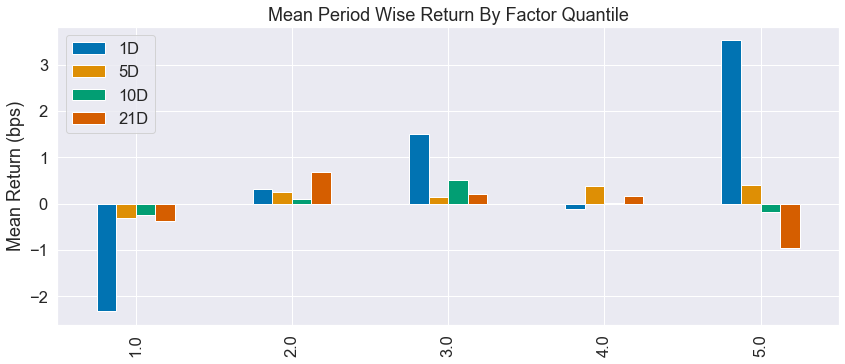

In [85]:
create_summary_tear_sheet(factor_data)

In [ ]:
create_full_tear_sheet(factor_data)